In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import os
import flwr as fl
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchsummary import summary
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from enum import Enum
from tqdm import tqdm
import gc
from numba import cuda
import networkx as nx
import random
import time
import enum
import threading
from matplotlib import pyplot as plt
from zod import ZodFrames
from zod import ZodSequences
import zod.constants as constants
from zod.constants import Camera, Lidar, Anonymization, AnnotationProject
import json
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import requests
import cv2
from flask import Flask, request, jsonify
import multiprocessing
from zod.visualization.oxts_on_image import visualize_oxts_on_image
from zod.constants import Camera
from zod.data_classes.calibration import Calibration
from zod.data_classes.oxts import EgoMotion
from zod.utils.polygon_transformations import polygons_to_binary_mask
from zod.utils.geometry import (
    get_points_in_camera_fov,
    project_3d_to_2d_kannala,
    transform_points,
)
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from pprint import pprint
from torch.utils.data import DataLoader
from PIL import Image
import sys
from statistics import mean
from ema_pytorch import EMA
import logging
import random
import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image
import math

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 200em; }</style>"))

/tmp/ipykernel_3899236/1829456096.py:42: DeprecationWarning: The 'zod.data_classes.oxts' module has been deprecated and will be removed in a future version. Please use the 'zod.data_classes.ego_motion' module instead.
  from zod.data_classes.oxts import EgoMotion


/tmp/ipykernel_3899236/1829456096.py:70: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## static params

In [24]:
config = {
        "exp_id": 3,
        "type": "centralized",
        "image_size": 224,
        "run_pretrained": True,
        "batch_size": 16,
        "val_factor": 0.1,
        "subset_factor": 0.0040,
        "labeled_factor": 0.80,
        "use_gpu": True,
        "num_clients": 1,
        "num_global_rounds": None,
        "num_local_epochs": 20,
        "print_debug_data": True,
        "num_workers": 10,
        "prefetch_factor": 32,
        "frames_image_mean": [0.337, 0.345, 0.367],
        "frames_image_std": [0.160, 0.180, 0.214],
        "learning_rate": 0.0001,
        "gpu_id": 0,
        "threshold":0.8,
        "lambda": 0.8
    }

# helper function to read from config
c = lambda a: config.get(a, None) 

IMG_SIZE = c('image_size')
RUN_PRETRAINED = c('run_pretrained')
BATCH_SIZE = c('batch_size')
VAL_FACTOR = c('val_factor')
SUBSET_FACTOR = c('subset_factor')
LABELED_FACTOR = c('labeled_factor')
USE_GPU = c('use_gpu')
NUM_CLIENTS = c('num_clients')
NUM_GLOBAL_ROUNDS = c('num_global_rounds')
NUM_LOCAL_EPOCHS = c('num_local_epochs')
LR=c('learning_rate')
ARC = 'FPN'
MODEL = 'resnet34'
IN_CHANNEL=3
OUT_CLASSES=1
NUM_WORKERS = c('num_workers')
PREFETCH_FACTOR = c('prefetch_factor')
FRAMES_IMAGE_MEAN = c('frames_image_mean')
FRAMES_IMAGE_STD = c('frames_image_std')
IMAGENET_MEAN=[0.485, 0.456, 0.406]
IMAGENET_STD=[0.229, 0.224, 0.225]
SEED=42
GPU_ID = c('gpu_id')
DEVICE = torch.device("cuda" if USE_GPU else "cpu")
TRAIN_FRAMES_PATH = "../GroundTruth/training_seg_annotated_frames.json"
VAL_FRAMES_PATH = "../GroundTruth/validation_seg_annotated_frames.json"
DATASET_ROOT = "/mnt/ZOD"
ZENSEACT_DATASET_ROOT = "/staging/dataset_donation/round_2"
THRESHOLD = c('threshold')
LAMBDA = c('lambda')

# specify the device
DEVICE = torch.device("cuda" if c('use_gpu') else "cpu")

print(f"PyTorch={torch.__version__}. Pytorch vision={torchvision.__version__}. Flower={fl.__version__}")
print(f"Training will run on: {DEVICE}s")

# path to tensor board persistent folders
DISC = f"exp-{c('exp_id')}_{c('type')}_imgnet_normalized_{c('num_local_epochs')}epochs_lr{c('learning_rate')}_{c('subset_factor')*52198}trainImages_bs{c('batch_size')}_imgSize{c('image_size')}"
now = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
TB_PATH = f"TensorBoard/{now}_{DISC}/"
TB_CENTRALIZED_SUB_PATH = "TensorBoard_Centralized/loss/"
TB_FEDERATED_SUB_PATH = "TensorBoard_Federated/loss/"
TB_SWARM_SUB_PATH = "TensorBoard_Swarm/loss/"
print(f'{DISC}_{now}')

# global tensorboard writer
writer = SummaryWriter(TB_PATH)

PyTorch=2.0.0+cu117. Pytorch vision=0.15.1+cu117. Flower=1.3.0
Training will run on: cudas
exp-3_centralized_imgnet_normalized_20epochs_lr0.0001_208.792trainImages_bs16_imgSize224_2023-05-23_01:51:45


## datasets

In [34]:
logger = logging.getLogger(__name__)

PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Posterize, 4, 4),
            (Sharpness, 0.9, 0.05),
            (Solarize, 256, 0),
            ]
    return augs


class RandAugmentPC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = my_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            prob = np.random.uniform(0.2, 0.8)
            if random.random() + prob >= 1:
                img = op(img, v=self.m, max_v=max_v, bias=bias)
        return img


class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img

In [39]:
class TransformFixMatch(object):
    def __init__(self, mean, std):
        self.weak = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.05),
        ])
        
        self.strong = transforms.Compose([
            RandAugmentMC(n=2, m=10)])
        
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(weak)
        return self.normalize(weak), self.normalize(strong)
    
def x_u_split(training_ids, validation_ids):
    labeled = random.sample(training_ids, k=int(len(training_ids)*LABELED_FACTOR))
    unlabeled = [x for x in training_ids if x not in labeled]
    print(len(labeled), 'are chosen as labeled and ', len(unlabeled), 'as unlabeled before augmentation')

    # make ids as tuple = (id, isLabeled)
    train_ids = [(x, True) for x in labeled]
    train_ids.extend([(x, False) for x in unlabeled])

    validation_ids =  [(x, True) for x in validation_ids]
    return train_ids, validation_ids

def boundary_loss(pred, target, smooth=1.):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    boundary_pred = torch.abs(torch.gradient(pred)[0])
    boundary_target = torch.abs(torch.gradient(target)[0])

    intersection = (boundary_pred * boundary_target).sum()
    union = boundary_pred.sum() + boundary_target.sum()
    loss = 1 - ((2. * intersection + smooth) / (union + smooth))

    return loss.mean()


def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (pred * target).sum()
    loss = (1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)))

    return loss.mean()


def compute_supervised_loss(preds, labels):
    # preds: Predicted segmentation masks by the model.
    # labels: Ground truth segmentation masks.
    B = preds.shape[0] # Get batch size

    # Initialize loss
    loss = 0

    # Loop over all images in the batch
    for b in range(B):
        # Compute Dice loss and Boundary loss for each image
        dl = dice_loss(preds[b], labels[b])
        bl = boundary_loss(preds[b], labels[b])
        # Add to total loss
        loss += dl + bl

    # Average the loss over the batch
    loss = loss / B

    return loss

def should_include_in_loss(pred_prob, threshold):
    max_confidences = pred_prob.squeeze(1) # [batch_size, height, width]
    avg_max_confidences = torch.mean(max_confidences, dim=[1, 2])
    mask = avg_max_confidences > threshold
    return mask

def compute_unsupervised_loss(pred_weak, pred_strong, threshold):
    pseudo_labels = (pred_weak > 0.5).float() # using 0.5 as a threshold to determine class
    mask = should_include_in_loss(pred_weak, threshold)
    
    loss = 0
    mask_sum = torch.sum(mask.float())
    
    if mask_sum.item() > 0:
        for b in range(mask.shape[0]):
            if mask[b]:
                dl = dice_loss(pred_strong[b].unsqueeze(0), pseudo_labels[b].unsqueeze(0)) # expand dimensions to match original dice_loss function requirements
                bl = boundary_loss(pred_strong[b].unsqueeze(0), pseudo_labels[b].unsqueeze(0)) # expand dimensions to match original boundary_loss function requirements
                loss += dl + bl
        loss = loss / mask_sum
    else:
        loss = torch.tensor(0.0, requires_grad=True).to(pred_weak.device)

    return loss

In [5]:
class ZODImporter:
    def __init__(
        self,
        root=DATASET_ROOT,
        subset_factor=SUBSET_FACTOR,
        img_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        tb_path=TB_PATH,
        zod_frames=None,
        training_frames=None, 
        validation_frames=None
    ):
        if(zod_frames == None):
            self.zod_frames, self.training_frames_all, self.validation_frames_all = load_ego_road(root)

            self.training_frames = self.training_frames_all[: int(len(self.training_frames_all) * subset_factor)]
            self.validation_frames = self.validation_frames_all[: int(len(self.validation_frames_all) * subset_factor)]

            self.training_frames = [x for x in tqdm(self.training_frames) if self.is_valid(x)]
            self.validation_frames = [x for x in tqdm(self.validation_frames) if self.is_valid(x)]
        else:
            self.zod_frames = zod_frames
            self.training_frames = training_frames
            self.validation_frames = validation_frames
            
        print("length of training_frames subset:", len(self.training_frames))
        print("length of test_frames subset:", len(self.validation_frames))

        self.img_size = img_size
        self.batch_size = batch_size
        self.tb_path = tb_path

        
    def is_valid(self, frame_id):
        zod_frame = self.zod_frames[frame_id]
        
        try:
            # get the ego road annotations
            polygon_annotations = zod_frame.get_annotation(AnnotationProject.EGO_ROAD)

            # convert the polygons to a binary mask (which can be used
            mask = polygons_to_binary_mask(polygon_annotations)
        except:
            print(f'{frame_id} is invalid')
            return False
        return True
        
    def get_zod_datasets(self):
        transform_labeled = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
        transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
        transform_fixmatch = TransformFixMatch(mean=IMAGENET_MEAN, std=IMAGENET_STD)

        train_ids, validation_ids = x_u_split(self.training_frames, self.validation_frames)

        train_dataset = ZodDataset(zod_frames=self.zod_frames, frames_id_set=train_ids, set_type='train', transform=transform_labeled, transform_fixmatch=transform_fixmatch)
        validation_set = ZodDataset(zod_frames=self.zod_frames, frames_id_set=validation_ids, set_type='val', transform=transform_val)

        return train_dataset, validation_set

    def load_datasets(self, num_clients: int):

        train_dataset, validation_set = self.get_zod_datasets()

        # Split training set into `num_clients` partitions to simulate different local datasets
        partition_size = len(train_dataset) // num_clients

        lengths = [partition_size]
        if num_clients > 1:
            lengths = [partition_size] * (num_clients - 1)
            lengths.append(len(train_dataset) - sum(lengths))

        datasets = random_split(train_dataset, lengths, torch.Generator().manual_seed(SEED))

        # Split each partition into train/val and create DataLoader
        # TODO: make loaders as tuple of labeled and unlabeled
        trainloaders, valloaders = [], []
        lengths_train, lengths_val = [], []
        for ds in datasets:
            len_val = int(len(ds) * VAL_FACTOR)
            len_train = int(len(ds) - len_val)
            lengths_train.append(len_train)
            lengths_val.append(len_val)
            lengths = [len_train, len_val]
            ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(SEED))
            trainloaders.append(DataLoader(ds_train,batch_size=self.batch_size, shuffle=True, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory= True))
            valloaders.append(DataLoader(ds_val, batch_size=self.batch_size, shuffle=True, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory= True))

        completeTrainloader = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=NUM_WORKERS, shuffle=True, prefetch_factor=PREFETCH_FACTOR, pin_memory= True)
        completeValloader = DataLoader(validation_set, batch_size=self.batch_size, num_workers=NUM_WORKERS, shuffle=True, prefetch_factor=PREFETCH_FACTOR, pin_memory= True)
        testloader = DataLoader(validation_set, batch_size=len(validation_set), num_workers=NUM_WORKERS, shuffle=True, prefetch_factor=PREFETCH_FACTOR, pin_memory= True)

        """report to tensor board"""
        save_dataset_tb_plot(self.tb_path, lengths_train, "training", SEED)
        save_dataset_tb_plot(self.tb_path, lengths_val, "validation", SEED)

        return (
            trainloaders,
            valloaders,
            testloader,
            completeTrainloader,
            completeValloader,
        )

class ZodDataset(Dataset):
    def __init__(
        self,
        zod_frames,
        frames_id_set,
        set_type,
        transform,
        transform_fixmatch=None
    ):
        self.zod_frames = zod_frames
        self.frames_id_set = frames_id_set
        self.transform = transform
        self.transform_fixmatch  = transform_fixmatch
        self.set_type = set_type

    def __len__(self):
        return len(self.frames_id_set)
    
    def __getitem__(self, idx):

        frame_idx, isLabeled = self.frames_id_set[idx]
        frame = self.zod_frames[frame_idx]
        
        image_path = frame.info.get_key_camera_frame(Anonymization.DNAT).filepath
            
        polygon_annotations = frame.get_annotation(AnnotationProject.EGO_ROAD)
        mask = polygons_to_binary_mask(polygon_annotations)

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = self._preprocess_mask(mask)

        sample = dict(image=image, mask=mask)
        
        # resize images
        image = np.array(Image.fromarray(sample["image"]).resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR))
        mask = np.array(Image.fromarray(sample["mask"]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))
        mask = np.expand_dims(mask, 0)

        # transform
        transformed_image = self.transform(image)
        if(self.set_type == 'train'):
            image_u_w, image_u_s = self.transform_fixmatch(image)
            sample["image_u_w"] = image_u_w
            sample["image_u_s"] = image_u_s

        sample["image"] = transformed_image
        sample["mask"] = mask
        sample["isLabeled"] = isLabeled

        return sample

    @staticmethod
    def _preprocess_mask(mask):
        mask = mask.astype(np.float32)
        mask[mask == False] = 0.0
        mask[mask == True] = 1.0
        return mask


def load_ego_road(dataset_root):
    zod_frames = ZodFrames(dataset_root=dataset_root, version="full")

    loaded_train_seg_annotated_frames = load_from_json(TRAIN_FRAMES_PATH)
    loaded_val_seg_annotated_frames = load_from_json(VAL_FRAMES_PATH)

    print(f'loaded {len(loaded_train_seg_annotated_frames)} train frame ids.')
    print(f'loaded {len(loaded_val_seg_annotated_frames)} val frame ids.')

    return zod_frames, loaded_train_seg_annotated_frames, loaded_val_seg_annotated_frames

def get_frame_seg_mask(zod_frames, frame_id):
    zod_frame = zod_frames[frame_id]

    mask = None
    try:
        # get the ego road annotations
        polygon_annotations = zod_frame.get_annotation(AnnotationProject.EGO_ROAD)

        # convert the polygons to a binary mask (which can be used
        mask = polygons_to_binary_mask(polygon_annotations)
    except:
        print(f'problem with frame {frame_id}')
        
    return mask

def save_to_json(path, data):
    with open(path, 'w') as f:
        f.write(json.dumps(data))
        
def load_from_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def save_dataset_tb_plot(tb_path, sample_distribution, subtitle, seed):
    plt.bar(list(range(1, len(sample_distribution) + 1)), sample_distribution)
    plt.xlabel("Partitions")
    plt.ylabel("Samples")
    plt.suptitle("Distribution of samples")
    plt.title("%s, seed: %s" % (subtitle, seed)),

    """report to tensor board"""
    writer = SummaryWriter(tb_path)
    writer.add_figure("sample_distribution/%s" % (subtitle), plt.gcf(), global_step=0)
    writer.close()

def dataset_visualize(train_dataset, valid_dataset, test_dataset):
    # lets look at some samples
    sample = train_dataset[0]
    plt.subplot(1,2,1)
    plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
    plt.subplot(1,2,2)
    plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
    plt.show()

    sample = valid_dataset[0]
    plt.subplot(1,2,1)
    plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
    plt.subplot(1,2,2)
    plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
    plt.show()

    sample = test_dataset[0]
    plt.subplot(1,2,1)
    plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
    plt.subplot(1,2,2)
    plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
    plt.show()

def predict_visualize(model, test_dataloader):
    batch = next(iter(test_dataloader))
    with torch.no_grad():
        model.eval()
        logits, _ = model(batch["image"])
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

## models

In [37]:
class PTModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.ema = EMA(
            self.model,
            beta=0.995,
            update_after_step=100,
            power=3/4,
            inv_gamma=1.0
        )
        
        # for image segmentation dice loss could be the best first choice
        self.DiceLoss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        self.epoch_counter = 1
        self.tb_log = {}
        self.create_intermediate_steps()

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        ema_mask = self.ema(image)
    
        return mask, ema_mask

    def shared_step(self, batch, stage, outputs):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask, ema_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        #loss = dice_loss(logits_mask, mask)
        #ema_loss = dice_loss(ema_mask, mask)
        loss = self.DiceLoss(logits_mask, mask) 
        ema_loss = self.DiceLoss(ema_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        if(stage == 'train'):
            self.ema.update()
        
        output = {
            "loss": loss,
            "ema_loss": ema_loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

        outputs.append(output)
        return output

    def shared_step_fixmatch(self, batch, stage, outputs):
        image = batch["image"]
        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= 0
        
        isLabeled = batch['isLabeled']
        labeled_idx = torch.where(isLabeled == True)[0].tolist()
        unlabeled_idx = [i for i in range(len(isLabeled)) if i not in labeled_idx]
        
        is_all_labeled = len(labeled_idx) == len(isLabeled)
        is_all_unlabeled = len(unlabeled_idx) == len(isLabeled)

        combinedLoss = None
        combinedEmaLoss = None

        if(stage != 'train'):
            logits_mask, ema_mask = self.forward(image)
            combinedLoss = self.DiceLoss(logits_mask, mask)
            combinedEmaLoss = self.DiceLoss(ema_mask, mask)

        else:
            loss_u = 0; loss = 0; ema_loss = 0

            image_u_w = batch['image_u_w']
            image_u_s = batch['image_u_s']

            image = image[labeled_idx]
            mask = mask[labeled_idx]

            image_u_w = image_u_w[unlabeled_idx]
            image_u_s = image_u_s[unlabeled_idx]

            logits_mask, ema_mask = self.forward(image)
            if(not is_all_labeled):
                logits_mask_u_w, _ = self.forward(image_u_w)
                logits_mask_u_s, _ = self.forward(image_u_s)

                loss_u = compute_unsupervised_loss(logits_mask_u_w, logits_mask_u_s, THRESHOLD)
            
            if(not is_all_unlabeled):
                loss = compute_supervised_loss(mask, logits_mask)
                ema_loss = compute_supervised_loss(mask, ema_mask)

            # combined loss
            combinedLoss = loss + LAMBDA * loss_u
            combinedEmaLoss = ema_loss + LAMBDA * loss_u

        tp, fp, fn, tn = None, None, None, None
        if(not is_all_unlabeled):
            # Lets compute metrics for some threshold
            # first convert mask values to probabilities, then 
            # apply thresholding
            prob_mask = logits_mask.sigmoid()
            pred_mask = (prob_mask > 0.5).float()

            # We will compute IoU metric by two ways
            #   1. dataset-wise
            #   2. image-wise
            # but for now we just compute true positive, false positive, false negative and
            # true negative 'pixels' for each image and class
            # these values will be aggregated in the end of an epoch
            tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        if(stage == 'train'):
            self.ema.update()
        
        output = {
            "loss": combinedLoss,
            "ema_loss": combinedEmaLoss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

        outputs.append(output)
        return output

    def shared_epoch_end(self, outputs, stage):

        # aggregate step metics
        tp = torch.cat([x['tp'] for x in outputs if x['tp'] != None])
        fp = torch.cat([x['fp'] for x in outputs if x['fp'] != None])
        fn = torch.cat([x['fn'] for x in outputs if x['fn'] != None])
        tn = torch.cat([x['tn'] for x in outputs if x['tn'] != None])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

        self.tb_log[f'{stage}_loss'] = np.mean([x['loss'].item() for x in outputs])
        self.tb_log[f'{stage}_ema_loss'] = np.mean([x['ema_loss'].item() for x in outputs])

        if(stage == 'train'):
            self.updateTB(self.tb_log, stage)
            self.epoch_counter +=1

    def training_step(self, batch, batch_idx):
        output = self.shared_step_fixmatch(batch, "train", self.inter_train_outputs)
        return output

    def on_train_epoch_end(self):
        return self.shared_epoch_end(self.inter_train_outputs, "train")

    def validation_step(self, batch, batch_idx):
        output = self.shared_step_fixmatch(batch, "valid", self.inter_val_outputs)
        return output

    def on_validation_epoch_end(self):
        return self.shared_epoch_end(self.inter_val_outputs, "valid")

    def test_step(self, batch, batch_idx):
        output = self.shared_step_fixmatch(batch, "test", self.inter_test_outputs)
        return output

    def on_test_epoch_end(self):
        return self.shared_epoch_end(self.inter_test_outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)
    
    def updateTB(self, tb_log, stage):
        writer.add_scalars('DiceLoss', tb_log, global_step=self.epoch_counter)
        self.create_intermediate_steps()

    def create_intermediate_steps(self):
        self.inter_train_outputs = []
        self.inter_val_outputs = []
        self.inter_test_outputs = []

        self.tb_log = {}

## train

In [7]:
def train(model, train_dataloader, valid_dataloader, nr_epochs=NUM_LOCAL_EPOCHS):
    trainer = pl.Trainer(
        accelerator= 'gpu',
        max_epochs=nr_epochs,
        default_root_dir='checkpoints',
        devices=[GPU_ID]
    )

    trainer.fit(
        model, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=valid_dataloader,
    )

    return trainer

def validate(trainer, model, valid_dataloader):
    valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
    pprint(valid_metrics)


def test(trainer, model, test_dataloader):
    test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
    pprint(test_metrics)


## supervised

In [10]:
def load_ego_road(dataset_root):
    zod_frames = ZodFrames(dataset_root=dataset_root, version="full")

    loaded_train_seg_annotated_frames = load_from_json(TRAIN_FRAMES_PATH)
    loaded_val_seg_annotated_frames = load_from_json(VAL_FRAMES_PATH)

    print(f'loaded {len(loaded_train_seg_annotated_frames)} train frame ids.')
    print(f'loaded {len(loaded_val_seg_annotated_frames)} val frame ids.')

    return zod_frames, loaded_train_seg_annotated_frames, loaded_val_seg_annotated_frames

def is_valid(zod_frames, frame_id):
    zod_frame = zod_frames[frame_id]

    try:
        # get the ego road annotations
        polygon_annotations = zod_frame.get_annotation(AnnotationProject.EGO_ROAD)

        # convert the polygons to a binary mask (which can be used
        mask = polygons_to_binary_mask(polygon_annotations)
    except:
        return False
    return True
    

zod_frames, training_frames_all, validation_frames_all = load_ego_road(DATASET_ROOT)

Loading infos: 0it [00:00, ?it/s]

loaded 52198 train frame ids.
loaded 5763 val frame ids.


In [22]:
training_frames = training_frames_all[: int(len(training_frames_all) * SUBSET_FACTOR)]
validation_frames = validation_frames_all[: int(len(validation_frames_all) * SUBSET_FACTOR)]

training_frames = [x for x in tqdm(training_frames) if is_valid(zod_frames,x)]
validation_frames = [x for x in tqdm(validation_frames) if is_valid(zod_frames,x)]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:03<00:00, 63.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.94it/s]


In [40]:
# get loaders
trainloaders, valloaders, testloader, completeTrainloader, completeValloader = ZODImporter(zod_frames=zod_frames,training_frames=training_frames,validation_frames=validation_frames).load_datasets(num_clients=1)

# create model
model = PTModel("FPN", "resnet34", in_channels=3, out_classes=1)

# train supervised
trainer = train(model, completeTrainloader, completeValloader, nr_epochs=NUM_LOCAL_EPOCHS)

length of training_frames subset: 208
length of test_frames subset: 23
166 are chosen as labeled and  42 as unlabeled before augmentation


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type     | Params
--------------------------------------
0 | model    | FPN      | 23.2 M
1 | ema      | EMA      | 46.3 M
2 | DiceLoss | DiceLoss | 0     
--------------------------------------
23.2 M    Trainable params
23.2 M    Non-trainable params
46.3 M    Total params
185.243   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# validate 
validate(trainer, model, completeValloader)

In [ ]:
# test
test(trainer, model, testloader)

In [ ]:
trainloaders, valloaders, testloader, completeTrainloader, completeValloader = ZODImporter(zod_frames=zod_frames,training_frames=training_frames,validation_frames=validation_frames).load_datasets(num_clients=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


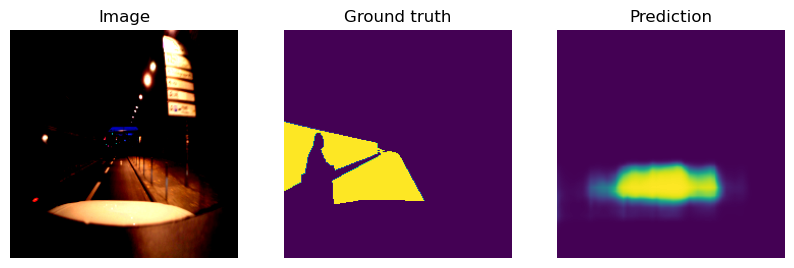

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


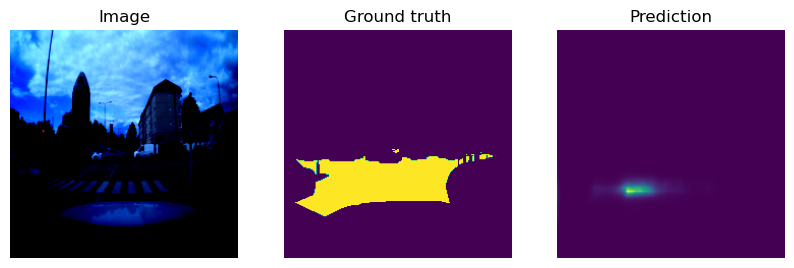

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


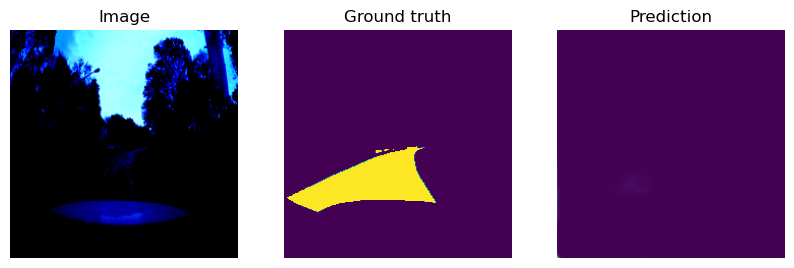

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


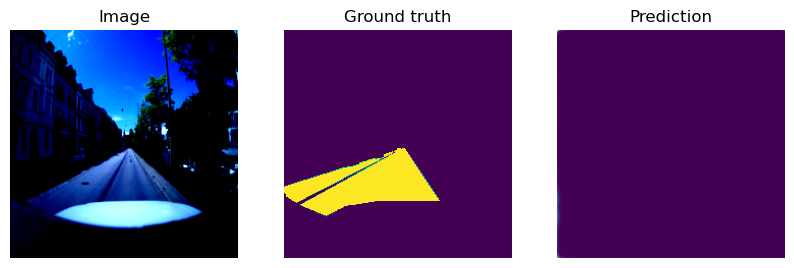

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


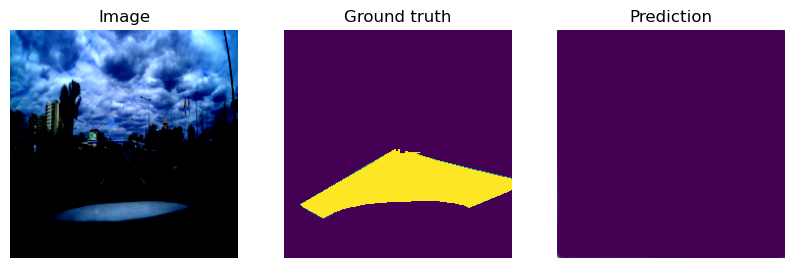

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


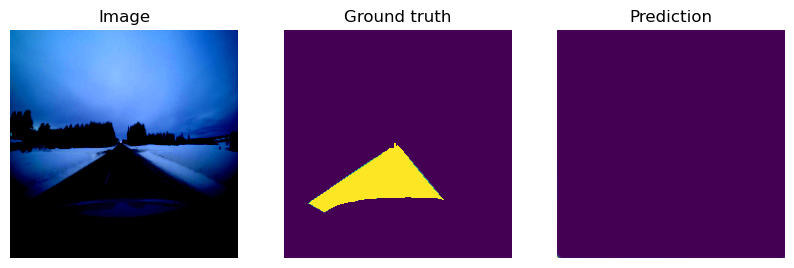

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


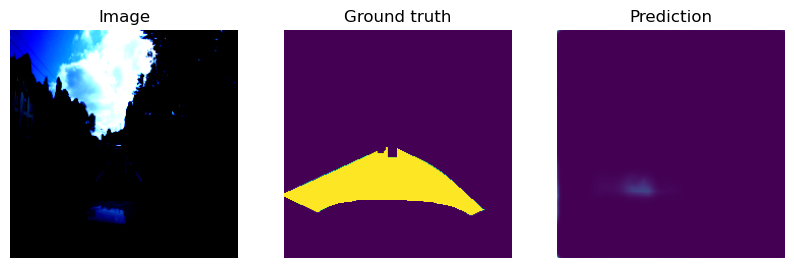

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


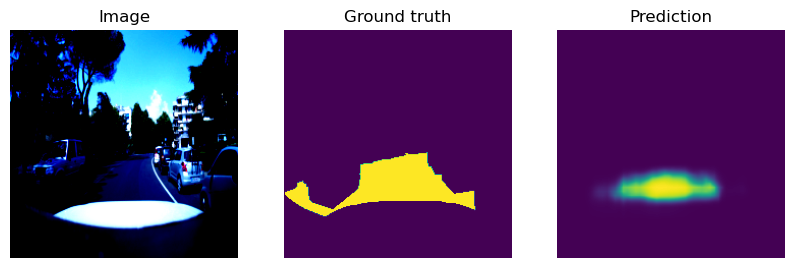

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


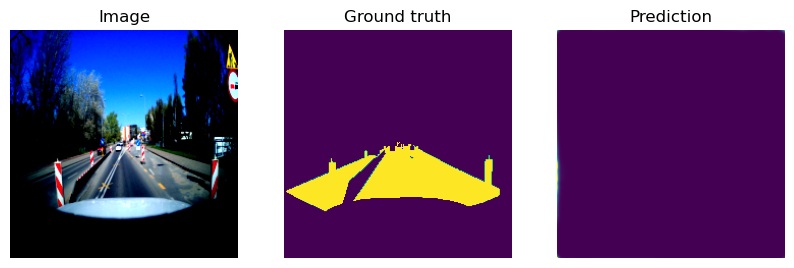

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


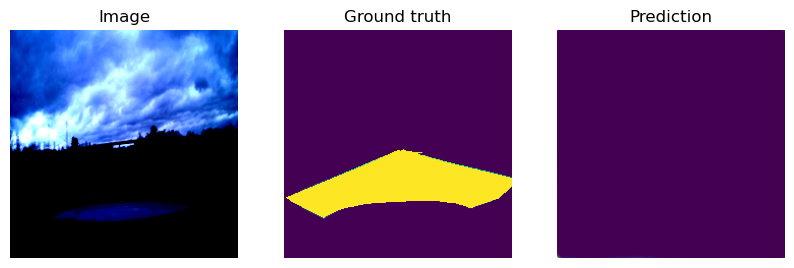

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


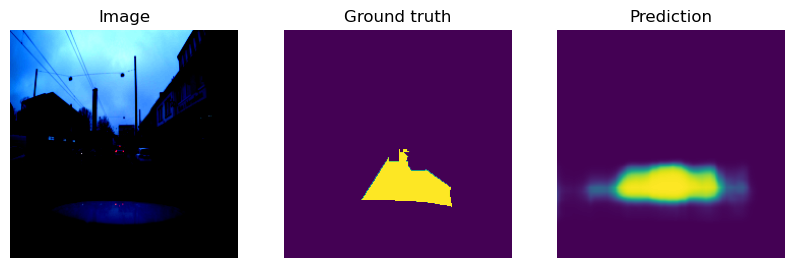

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


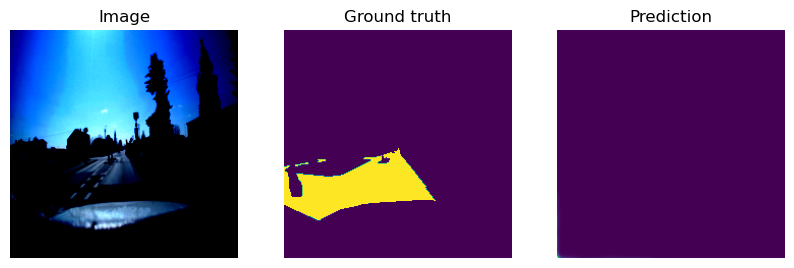

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


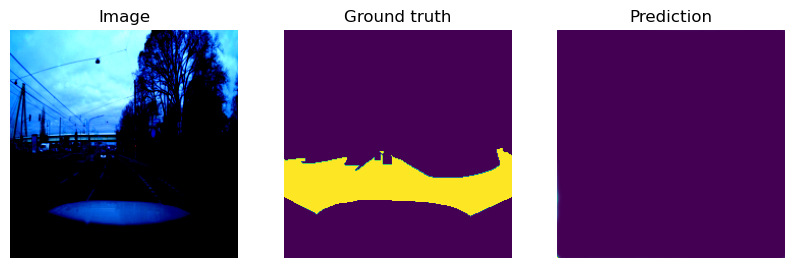

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


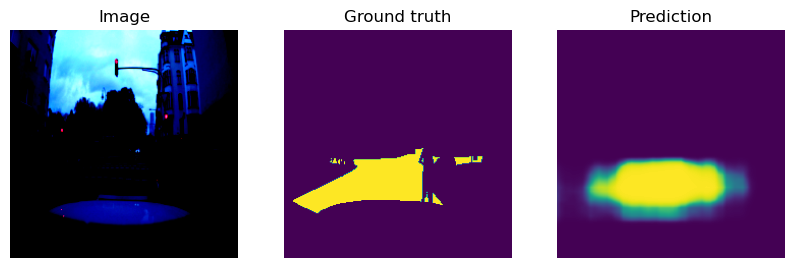

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


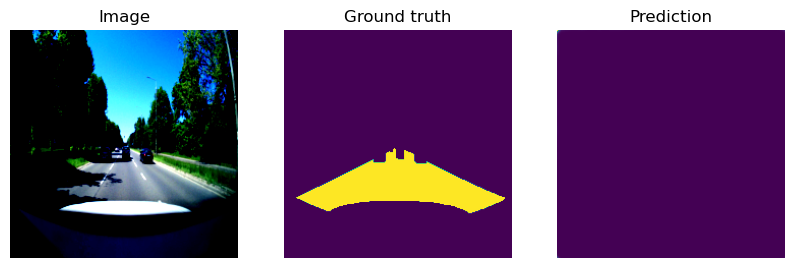

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


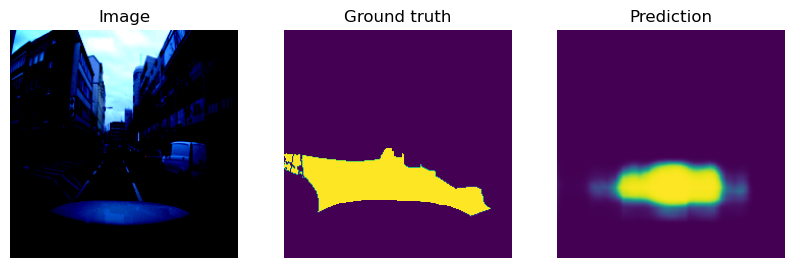

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


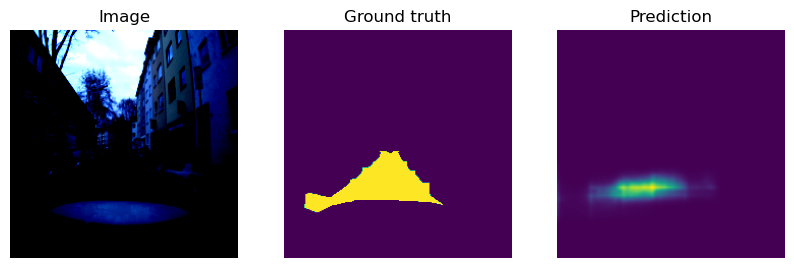

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


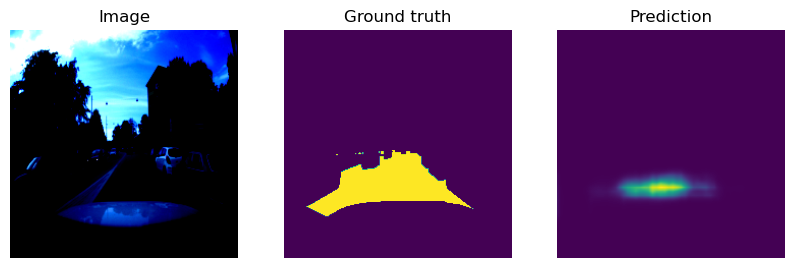

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


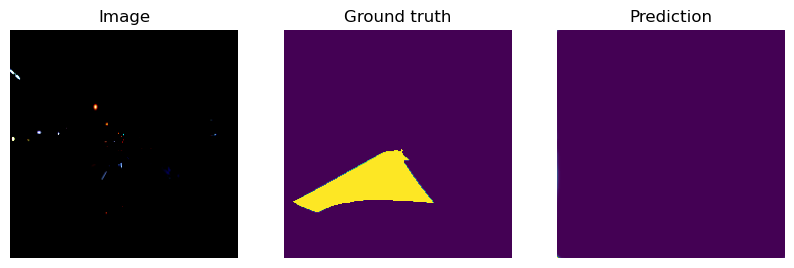

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


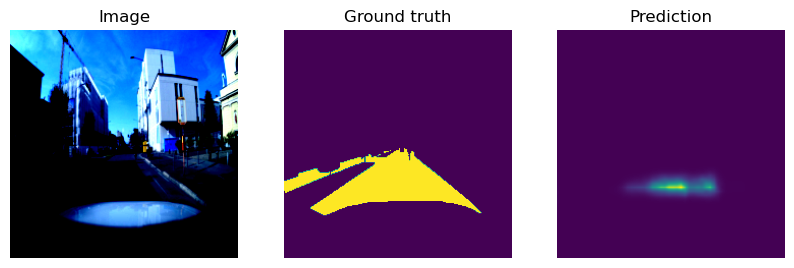

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


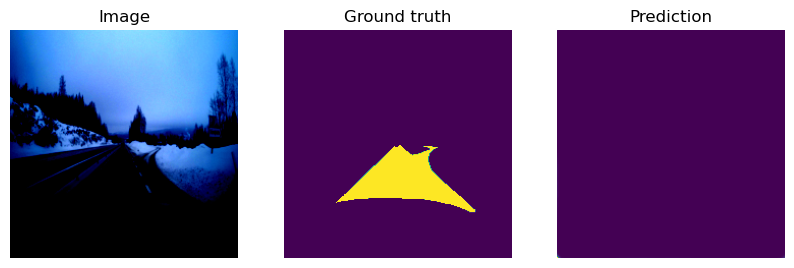

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


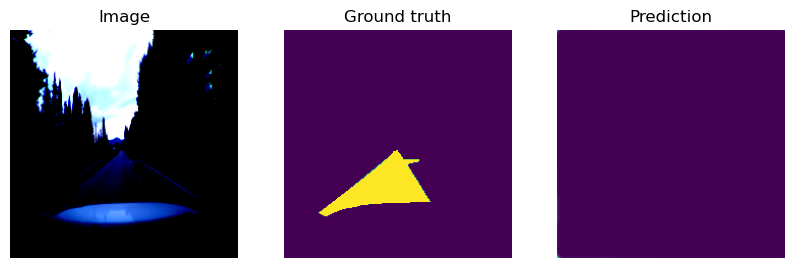

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


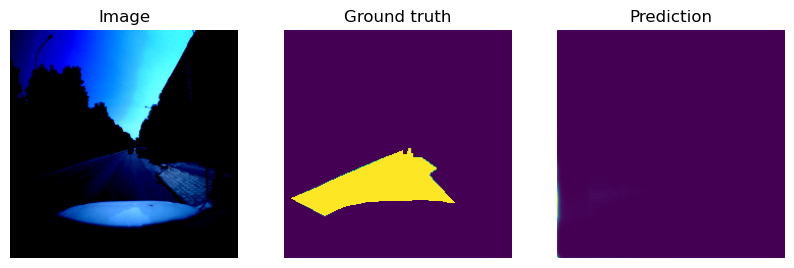

In [43]:
#dataset_visualize(completeTrainloader.dataset, completeValloader.dataset, testloader.dataset)
predict_visualize(model, testloader)

In [ ]:
checkpoint_path = 'epoch=97-step=24010.ckpt'
m = PTModel.load_from_checkpoint(checkpoint_path=checkpoint_path, arch="FPN", encoder_name="resnet34", in_channels=3, out_classes=1) 
predict_visualize(m, testloader)

In [ ]:
        image = batch["image"]
        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= 0

        image_u_w = batch["image_u_w"]
        image_u_s = batch["image_u_s"]

        isLabeled = batch["isLabeled"][0].tolist()
        labeled_idx = np.where(isLabeled)[0].tolist()
        unlabeled_idx = np.where(not isLabeled)[0].tolist()

        labeled_images = image[labeled_idx]
        masks = masks[labeled_idx]

        unlabeled_image_u_w = image_u_w[unlabeled_idx]
        unlabeled_image_u_s = image_u_s[unlabeled_idx]

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 64em; }</style>"))



In [ ]:
torch.tensor([1,2,3]) + 0